# 可解释和因果性 v1.0

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt

In [89]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [2]:
# 测试集
from mydata.adult import X_train, y_train, X_test, y_test, sex, feature_index # 获得 数据集 测试集 和 测试集上的敏感属性

In [34]:
def map_sex_float_2_int(y):
    return 1 if y > 0 else 0

In [35]:
y_protect_train = X_train['sex'].map(map_sex_float_2_int)
y_protect_test = X_test['sex'].map(map_sex_float_2_int)
y_protect_train.head()

0    0
1    1
2    0
3    1
4    1
Name: sex, dtype: int64

In [36]:
# 训练集 去除某一列
X_non_protect_train = X_train.drop('sex', axis=1)
X_non_protect_test = X_test.drop('sex', axis=1)
X_non_protect_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,capital.gain,capital.loss,hours.per.week,native.country
0,0.101484,2.600478,-1.494279,-0.332263,1.133894,-0.402341,-0.782234,2.214196,0.39298,-0.145189,-0.217407,-1.662414,0.262317
1,0.028248,-1.884720,0.438778,0.184396,-0.423425,-0.402341,-0.026696,-0.899410,0.39298,-0.145189,-0.217407,-0.200753,0.262317
2,0.247956,-0.090641,0.045292,1.217715,-0.034095,0.926666,-0.782234,-0.276689,0.39298,-0.145189,-0.217407,-0.038346,0.262317
3,-0.850587,-1.884720,0.793152,0.184396,-0.423425,0.926666,-0.530388,0.968753,0.39298,-0.145189,-0.217407,-0.038346,0.262317
4,-0.044989,-2.781760,-0.853275,0.442726,1.523223,-0.402341,-0.782234,-0.899410,0.39298,-0.145189,-0.217407,-0.038346,0.262317


In [37]:
X_non_protect_train.shape, y_protect_train.shape, X_train.shape, y_train.shape
# X_non_protect_train.info()
# y_protect_train.info()

((22792, 13), (22792,), (22792, 14), (22792,))

In [38]:
# 训练
import xgboost
xgboost_model = xgboost.XGBRegressor()
xgboost_model.fit(X_non_protect_train, y_protect_train)
# 预测
y_protect_pred = xgboost_model.predict(X_non_protect_test)
y_protect_pred

array([0.19320935, 0.7650606 , 0.5399524 , ..., 0.6643013 , 0.1727541 ,
       1.0149455 ], dtype=float32)

In [51]:
y_protect_pred_int = np.where(y_protect_pred > 0.5, 1, 0)

In [52]:
from sklearn.metrics import (accuracy_score)

accuracy_score(y_protect_test, y_protect_pred_int)

0.8475790766711024

In [53]:
import shap

In [54]:
explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X_non_protect_train)

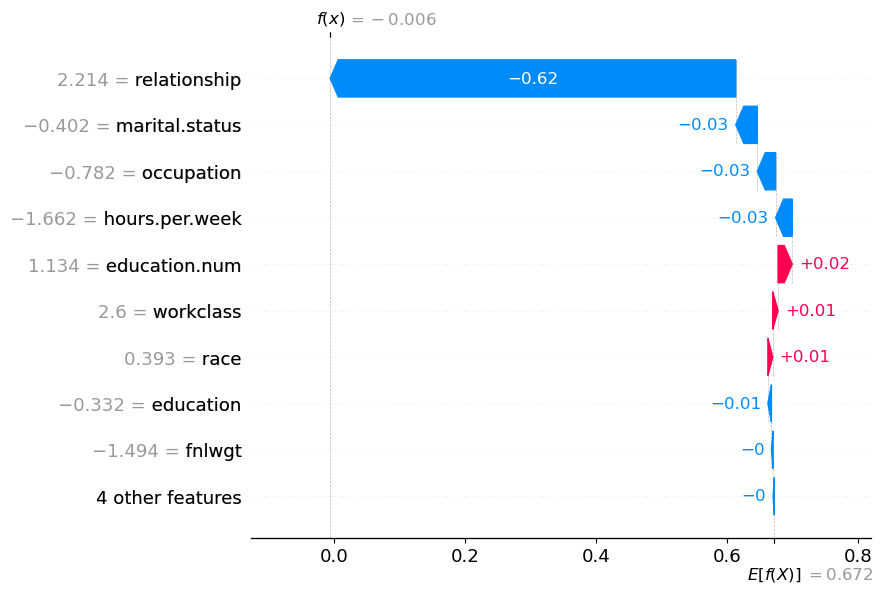

In [55]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


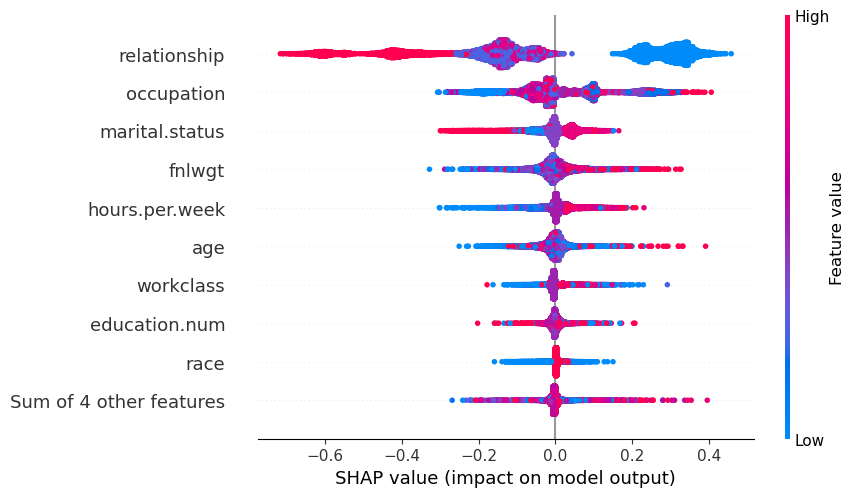

In [56]:
shap.plots.beeswarm(shap_values)

## Baseline

In [57]:
X_train, y_train, X_test, y_test
print("hello, train")

hello, train

In [58]:
xgboost_origin = xgboost.XGBRegressor()
xgboost_origin.fit(X_train, y_train)
y_pred = xgboost_origin.predict(X_test)
y_pred[:5]
y_pred_int = np.where(y_pred > 0.5, 1, 0)

In [69]:
from utils.helper import test_model
from model.models import train_model_and_test

In [79]:
model_origin, res_origin = train_model_and_test(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    test_func=test_model,
    sensitive_feature=sex,
    model_cls=xgboost.XGBRegressor,
    desc="baseline",
)

In [80]:
res_origin

{'准确率[1.]': 0.8624219469751254,
 '精确率[1.]': 0.7683765203595981,
 '召回率[1.]': 0.6159389571852479,
 'FPR[0.]': 0.05910931174089069,
 'FNR[0.]': 0.384061042814752,
 'F1 Score[1.]': 0.6837647058823529,
 '人口平等 差异[0.]': 0.16989595884523423,
 '人口平等 比率[1.]': 0.32250719180485066,
 '机会均等 差异[0.]': 0.08764799066199769,
 '机会均等 比率[1.]': 0.29597011190360795}

## 实验组

我们现在知道 relationship 可能会对公平性有影响

因为 relationship 可能含有 sex 的潜在信息

那我们怎么做才能消除这个影响呢？



### 方法 1 删除 sex 列

In [81]:
X_m1_train = X_train.drop('sex', axis=1)
X_m1_test = X_test.drop('sex', axis=1)
X_m1_train.shape, X_train.shape

((22792, 13), (22792, 14))

In [82]:
model_m1, res_m1 = train_model_and_test(
    X_train=X_m1_train,
    y_train=y_train,
    X_test=X_m1_test,
    y_test=y_test,
    test_func=test_model,
    sensitive_feature=sex,
    model_cls=xgboost.XGBRegressor,
    desc="baseline",
)

In [83]:
res_m1

{'准确率[1.]': 0.8636503224485618,
 '精确率[1.]': 0.7678664580073031,
 '召回率[1.]': 0.6239932174650276,
 'FPR[0.]': 0.06005398110661268,
 'FNR[0.]': 0.37600678253497244,
 'F1 Score[1.]': 0.6884939195509823,
 '人口平等 差异[0.]': 0.17115811590449273,
 '人口平等 比率[1.]': 0.32577228506923234,
 '机会均等 差异[0.]': 0.10043077094102615,
 '机会均等 比率[1.]': 0.3251502637814284}

### 方法 2：删除 relation-ship 列

In [84]:
X_m2_train = X_train.drop('relationship', axis=1)
X_m2_test = X_test.drop('relationship', axis=1)
X_m2_train.shape, X_train.shape

((22792, 13), (22792, 14))

In [85]:
model_m2, res_m2 = train_model_and_test(
    X_train=X_m2_train,
    y_train=y_train,
    X_test=X_m2_test,
    y_test=y_test,
    test_func=test_model,
    sensitive_feature=sex,
    model_cls=xgboost.XGBRegressor,
    desc="baseline",
)

In [86]:
res_m2

{'准确率[1.]': 0.8652881564131436,
 '精确率[1.]': 0.776657824933687,
 '召回率[1.]': 0.6206019499788046,
 'FPR[0.]': 0.05681511470985155,
 'FNR[0.]': 0.3793980500211954,
 'F1 Score[1.]': 0.6899151743638077,
 '人口平等 差异[0.]': 0.1808875169382416,
 '人口平等 比率[1.]': 0.28744613388461676,
 '机会均等 差异[0.]': 0.13576510477460957,
 '机会均等 比率[1.]': 0.24444262608078993}

In [87]:
df = pd.DataFrame([res_origin, res_m1, res_m2],index=["origin", "res_m1", "res_m2"])
df

,准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,0.862422,0.768377,0.615939,0.059109,0.384061,0.683765,0.169896,0.322507,0.087648,0.295970
res_m1,0.863650,0.767866,0.623993,0.060054,0.376007,0.688494,0.171158,0.325772,0.100431,0.325150
res_m2,0.865288,0.776658,0.620602,0.056815,0.379398,0.689915,0.180888,0.287446,0.135765,0.244443


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

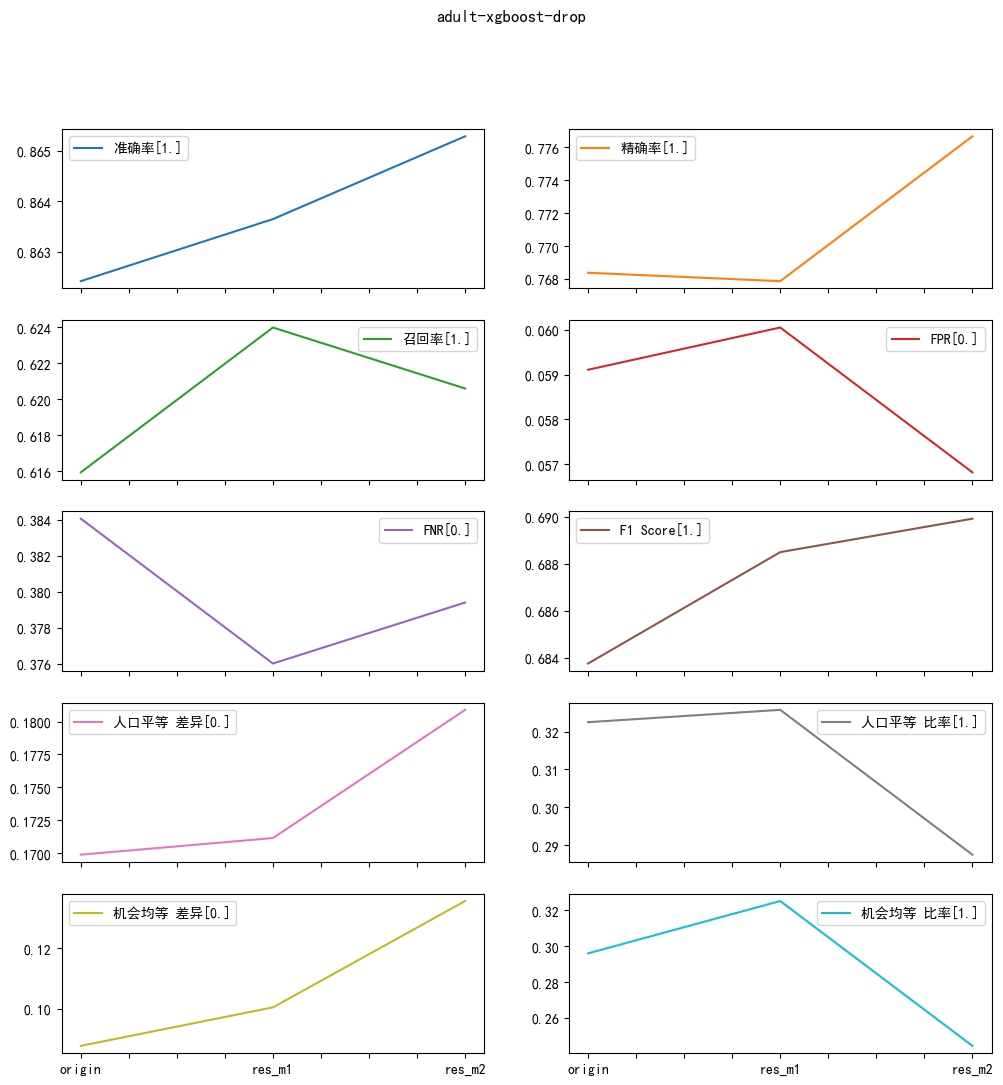

In [90]:
title = "adult-xgboost-drop"
df.plot(
    title=title,
    subplots=True, 
    layout=(5, 2), 
    figsize=(12, 12), 
    kind='line',
)

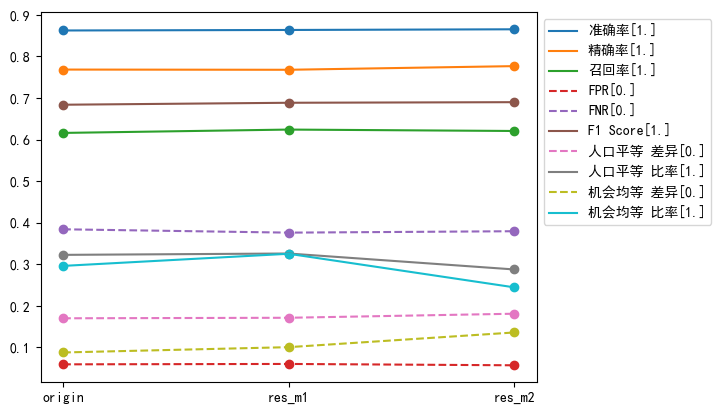

In [107]:
# 画在一张图上
cmap = plt.get_cmap('tab10')

# 初始化图例对象
scatter_legend = []

for i, col in enumerate(df.columns):
    values = df[col].values
    x = df.index
    if "[1.]" in col:
        # 绘制折线图
        line = plt.plot(x, values, label=col, color=cmap(i))
    else:
        line = plt.plot(x, values, linestyle="dashed", label=col, color=cmap(i))
    # 绘制点图
    scatter = plt.scatter(x, values, color=cmap(i))

    # 将散点图的图例对象添加到列表中
    scatter_legend.append(scatter)


plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

## 结论

直接删除列的效果并不好